#### Reduced Diabetes

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'reduced_diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = 4
num_epochs = 1000
batch_size = 32

for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    # Initialize model
    model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
    optimizer = Adam(model.parameters(), lr=0.001)
    
    # Convert data to tensor
    X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            
            reconstructed = model(batch)
            loss = 0
            
            # Calculate per-feature loss
            start_idx = 0
            for j, (ftype, params) in enumerate(feature_info):
                if ftype == 'categorical':
                    end_idx = start_idx + params['num_classes']
                    loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                          batch[:, j].long())
                    start_idx = end_idx
                else:
                    end_idx = start_idx + 1
                    if ftype == 'binary':
                        loss += F.binary_cross_entropy_with_logits(
                            reconstructed[:, start_idx], batch[:, j])
                    else:
                        loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                    start_idx = end_idx
            
            loss.backward()
            optimizer.step()
    
    # Generate latent space
    with torch.no_grad():
        latent = model.encode(X_tensor).numpy()
    
    # Apply Forest Diffusion
    forest_model = ForestDiffusionModel(
        X=latent,
        n_t=50,
        duplicate_K=100,
        diffusion_type='flow',
        n_jobs=-1
    )
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['Outcome'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



Results for multiplier=0.25


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.6471
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       151
           1       0.92      0.65      0.76        17

    accuracy                           0.96       168
   macro avg       0.94      0.82      0.87       168
weighted avg       0.96      0.96      0.96       168

Results for multiplier=0.5


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.5294
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       151
           1       0.82      0.53      0.64        17

    accuracy                           0.94       168
   macro avg       0.88      0.76      0.81       168
weighted avg       0.94      0.94      0.93       168

Results for multiplier=0.75


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       151
           1       0.88      0.88      0.88        17

    accuracy                           0.98       168
   macro avg       0.93      0.93      0.93       168
weighted avg       0.98      0.98      0.98       168

Results for multiplier=1


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.8235
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       151
           1       0.88      0.82      0.85        17

    accuracy                           0.97       168
   macro avg       0.93      0.91      0.92       168
weighted avg       0.97      0.97      0.97       168

Results for multiplier=1.25


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 1.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       151
           1       0.81      1.00      0.89        17

    accuracy                           0.98       168
   macro avg       0.90      0.99      0.94       168
weighted avg       0.98      0.98      0.98       168

Results for multiplier=1.5


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       151
           1       0.94      0.94      0.94        17

    accuracy                           0.99       168
   macro avg       0.97      0.97      0.97       168
weighted avg       0.99      0.99      0.99       168

Results for multiplier=1.75


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       151
           1       0.88      0.88      0.88        17

    accuracy                           0.98       168
   macro avg       0.93      0.93      0.93       168
weighted avg       0.98      0.98      0.98       168

Results for multiplier=2


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       151
           1       0.89      0.94      0.91        17

    accuracy                           0.98       168
   macro avg       0.94      0.96      0.95       168
weighted avg       0.98      0.98      0.98       168

Results for multiplier=2.25


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       151
           1       0.84      0.94      0.89        17

    accuracy                           0.98       168
   macro avg       0.92      0.96      0.94       168
weighted avg       0.98      0.98      0.98       168

Results for multiplier=2.5


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 1.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       151
           1       0.85      1.00      0.92        17

    accuracy                           0.98       168
   macro avg       0.93      0.99      0.95       168
weighted avg       0.98      0.98      0.98       168

Results for multiplier=2.75


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 1.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       151
           1       0.77      1.00      0.87        17

    accuracy                           0.97       168
   macro avg       0.89      0.98      0.93       168
weighted avg       0.98      0.97      0.97       168

Results for multiplier=3


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Recall score (original data): 0.1765
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       151
           1       0.80      0.94      0.86        17

    accuracy                           0.97       168
   macro avg       0.90      0.96      0.92       168
weighted avg       0.97      0.97      0.97       168



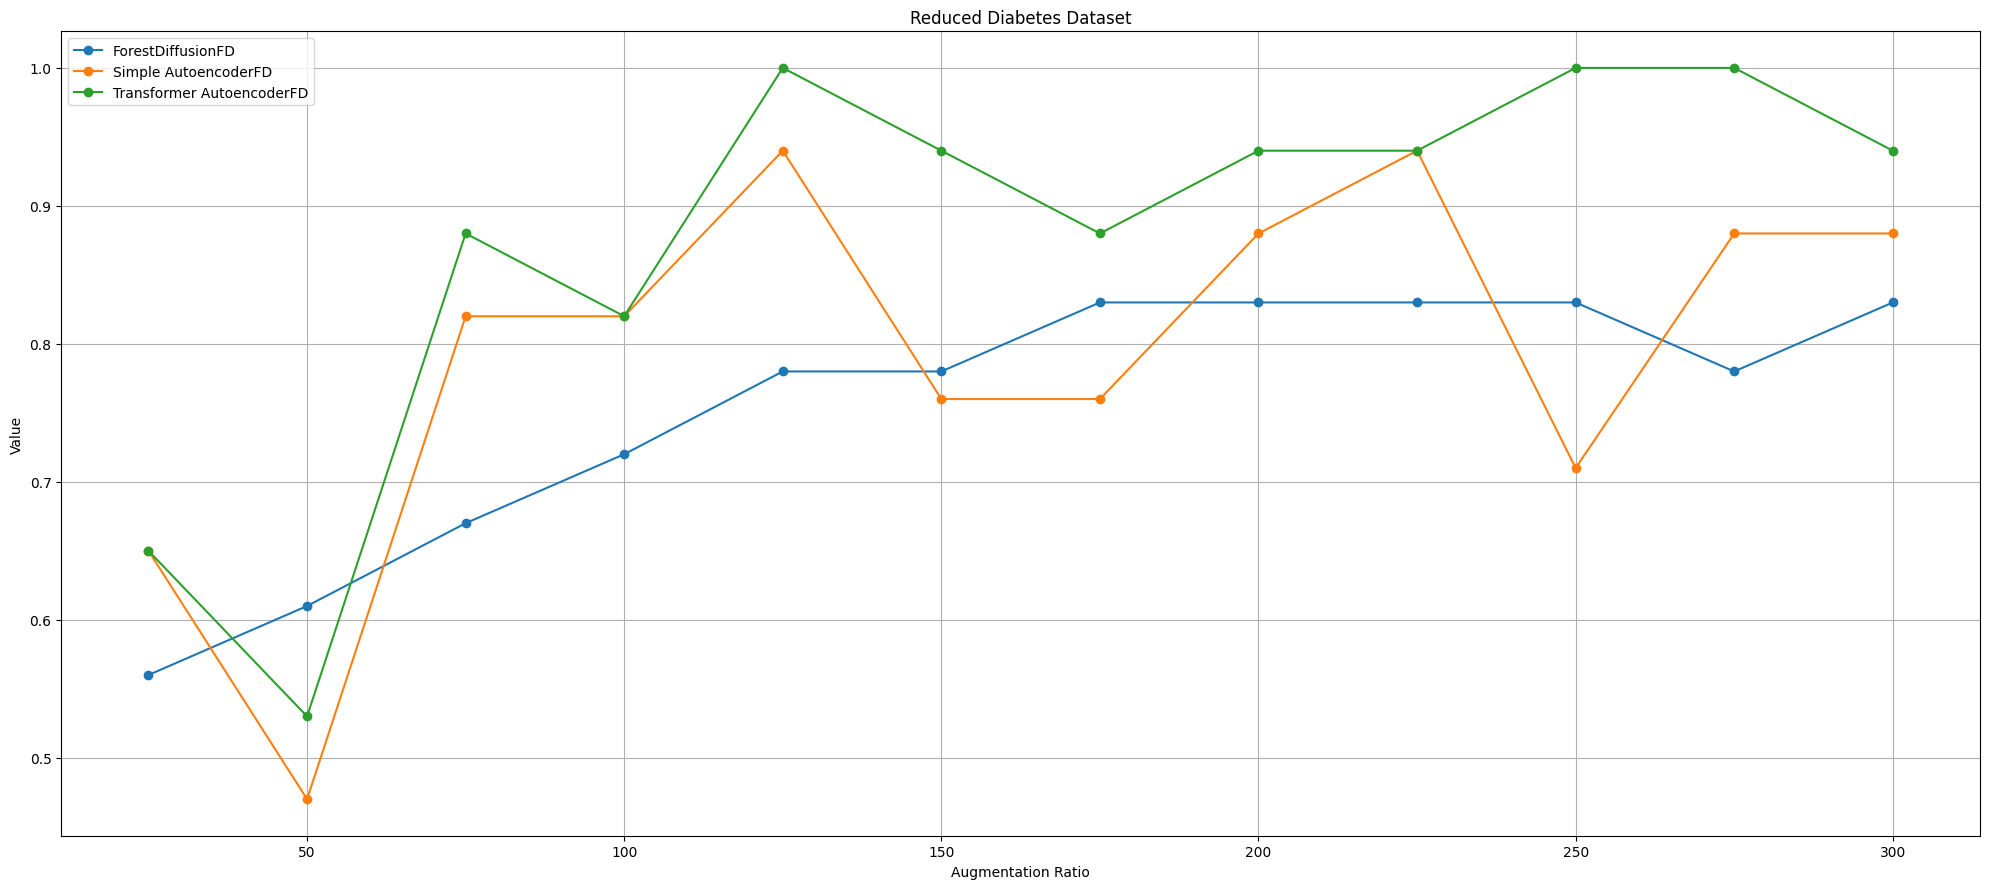

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x_values = list(range(25, 301, 25))
forest_diffusion = [0.56, 0.61, 0.67, 0.72, 0.78, 0.78, 0.83, 0.83, 0.83, 0.83, 0.78, 0.83]
simple_autoencoder_diffusion = [0.65, 0.47, 0.82, 0.82, 0.94, 0.76, 0.76, 0.88, 0.94, 0.71, 0.88, 0.88]
transformer_autoencoder_diffusion = [0.65, 0.53, 0.88, 0.82, 1.0, 0.94, 0.88, 0.94, 0.94, 1.0,1.0, 0.94]

# Create the plot
plt.figure(figsize=(20, 9))  # Adjust figure size as needed

# Plot each line
plt.plot(x_values,forest_diffusion, label='ForestDiffusionFD', marker='o')
plt.plot(x_values,simple_autoencoder_diffusion, label='Simple AutoencoderFD', marker='o')
plt.plot(x_values,transformer_autoencoder_diffusion, label='Transformer AutoencoderFD', marker='o')

# Add labels and title
plt.xlabel('Augmentation Ratio')
plt.ylabel('Value')
plt.title('Reduced Diabetes Dataset')
plt.legend()
plt.grid(True) # adds a grid to the background of the plot

# Show the plot
plt.tight_layout() # prevents labels from being cut off
plt.show()

#### Mammography

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'mammography'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = 4
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['target'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25
Recall score (original data): 0.5946
Recall score (generated data): 0.7027
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99      3281
           1       0.92      0.59      0.72        74

    accuracy                           0.99      3355
   macro avg       0.95      0.80      0.86      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.99      1.00      1.00      3281
           1       0.96      0.70      0.81        74

    accuracy                           0.99      3355
   macro avg       0.98      0.85      0.90      3355
weighted avg       0.99      0.99      0.99      3355

Results for multiplier=0.5
Recall score (original data): 0.5946
Recall score (generated data): 0.7297
Classification Report (original data):
               precis

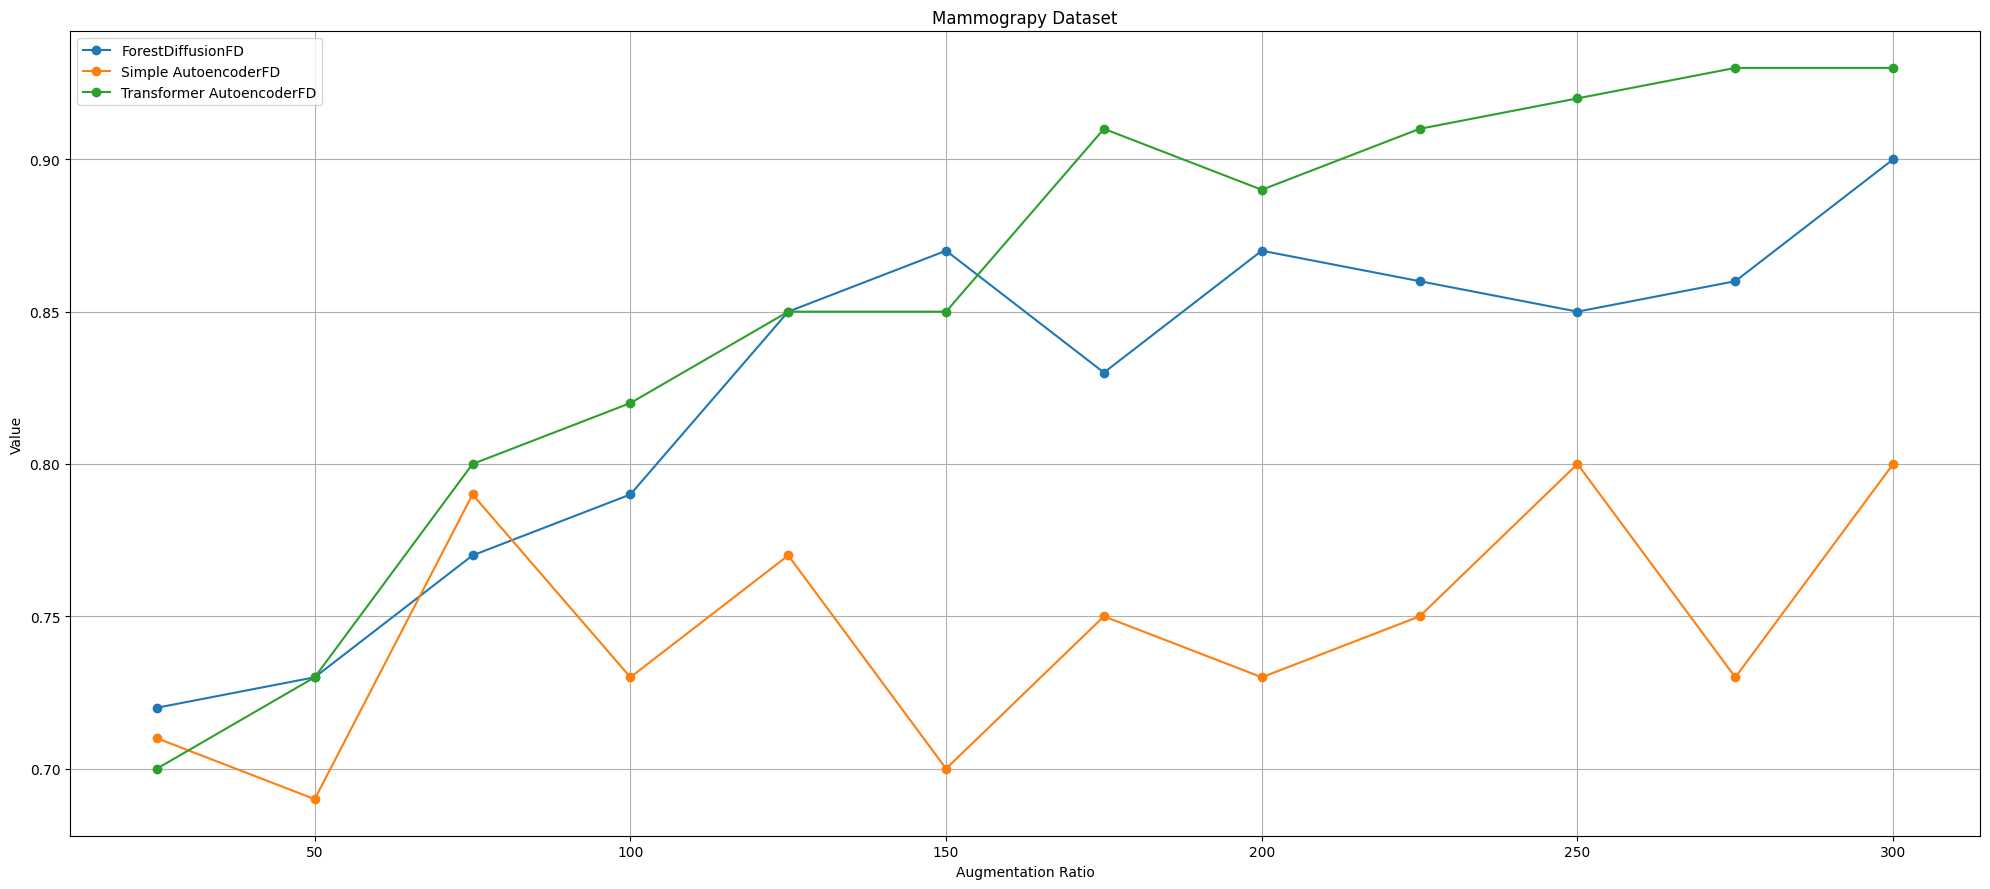

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x_values = list(range(25, 301, 25))
forest_diffusion = [0.72, 0.73, 0.77, 0.79, 0.85, 0.87, 0.83, 0.87, 0.86, 0.85, 0.86, 0.90]
simple_autoencoder_diffusion = [0.71, 0.69, 0.79, 0.73, 0.77, 0.7, 0.75, 0.73, 0.75, 0.8, 0.73, 0.8]
transformer_autoencoder_diffusion = [0.7, 0.73, 0.8, 0.82, 0.85, 0.85, 0.91, 0.89, 0.91, 0.92, 0.93, 0.93]

# Create the plot
plt.figure(figsize=(20, 9))  # Adjust figure size as needed

# Plot each line
plt.plot(x_values,forest_diffusion, label='ForestDiffusionFD', marker='o')
plt.plot(x_values,simple_autoencoder_diffusion, label='Simple AutoencoderFD', marker='o')
plt.plot(x_values,transformer_autoencoder_diffusion, label='Transformer AutoencoderFD', marker='o')

# Add labels and title
plt.xlabel('Augmentation Ratio')
plt.ylabel('Value')
plt.title('Mammograpy Dataset')
plt.legend()
plt.grid(True) # adds a grid to the background of the plot

# Show the plot
plt.tight_layout() # prevents labels from being cut off
plt.show()

#### Reduced smart grid stability

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'reduced_smart_grid_stability'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = 4
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['stabf'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25
Recall score (original data): 0.4338
Recall score (generated data): 0.8742
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1912
           1       0.96      0.43      0.60       302

    accuracy                           0.92      2214
   macro avg       0.94      0.72      0.78      2214
weighted avg       0.92      0.92      0.91      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1912
           1       0.97      0.87      0.92       302

    accuracy                           0.98      2214
   macro avg       0.97      0.93      0.95      2214
weighted avg       0.98      0.98      0.98      2214

Results for multiplier=0.5
Recall score (original data): 0.4338
Recall score (generated data): 0.8874
Classification Report (original data):
               precis

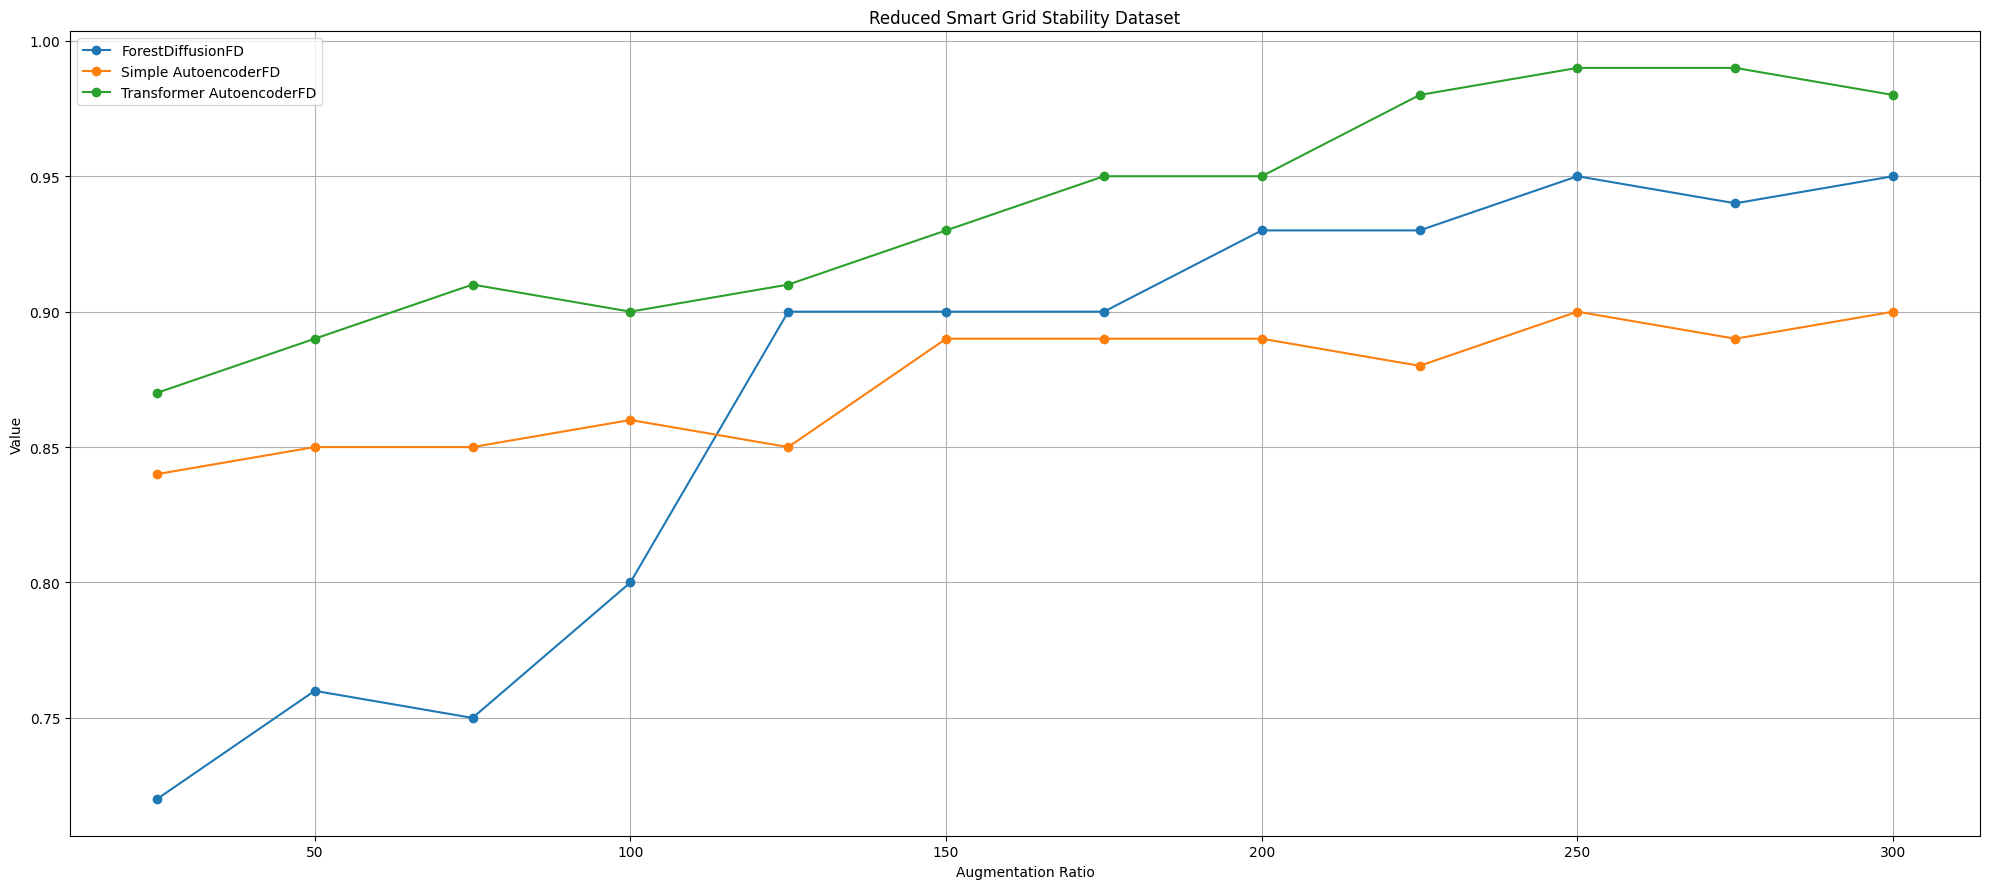

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x_values = list(range(25, 301, 25))
forest_diffusion = [0.72, 0.76, 0.75, 0.8, 0.9, 0.9, 0.9, 0.93, 0.93, 0.95, 0.94, 0.95]
simple_autoencoder_diffusion = [0.84, 0.85, 0.85, 0.86, 0.85, 0.89, 0.89, 0.89, 0.88, 0.9, 0.89, 0.9]
transformer_autoencoder_diffusion = [0.87, 0.89, 0.91, 0.9, 0.91, 0.93, 0.95, 0.95, 0.98, 0.99, 0.99, 0.98]

# Create the plot
plt.figure(figsize=(20, 9))  # Adjust figure size as needed

# Plot each line
plt.plot(x_values,forest_diffusion, label='ForestDiffusionFD', marker='o')
plt.plot(x_values,simple_autoencoder_diffusion, label='Simple AutoencoderFD', marker='o')
plt.plot(x_values,transformer_autoencoder_diffusion, label='Transformer AutoencoderFD', marker='o')

# Add labels and title
plt.xlabel('Augmentation Ratio')
plt.ylabel('Value')
plt.title('Reduced Smart Grid Stability Dataset')
plt.legend()
plt.grid(True) # adds a grid to the background of the plot

# Show the plot
plt.tight_layout() # prevents labels from being cut off
plt.show()

#### Reduced Cardio Train

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'reduced_cardio_train'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = 4
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['cardio'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25
Recall score (original data): 0.0840
Recall score (generated data): 0.7067
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     10517
           1       0.37      0.08      0.14      1190

    accuracy                           0.89     11707
   macro avg       0.64      0.53      0.54     11707
weighted avg       0.85      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     10517
           1       0.83      0.71      0.76      1190

    accuracy                           0.96     11707
   macro avg       0.90      0.84      0.87     11707
weighted avg       0.95      0.96      0.95     11707

Results for multiplier=0.5
Recall score (original data): 0.0840
Recall score (generated data): 0.7269
Classification Report (original data):
               precis

#### coil_2000

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'coil_2000'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = len(data.columns)//2
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                # Ensure vals has the correct shape
                vals = vals.reshape(-1, 1)
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals)
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['cardio'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25


ValueError: non-broadcastable output operand with shape (146,1) doesn't match the broadcast shape (146,4)

#### Oil

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'oil'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = len(data.columns)//2
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['target'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25


ValueError: non-broadcastable output operand with shape (10,1) doesn't match the broadcast shape (10,2)

Credit card

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'creditcard'
file_path = f'..\\..\\..\\..\\Extra_Datasets\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = 4
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df['Class'] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25
Recall score (original data): 0.8015
Recall score (generated data): 0.9191
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.80      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.92      0.93       136

    accuracy                           1.00     85443
   macro avg       0.97      0.96      0.96     85443
weighted avg       1.00      1.00      1.00     85443

Results for multiplier=0.5
Recall score (original data): 0.8015
Recall score (generated data): 0.9265
Classification Report (original data):
               precis

#### Reduced Spambase

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
# from ForestDiffusion import ForestDiffusionModel    # If needed
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# Tabular Transformer Autoencoder
# -------------------------------
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads (one per feature)
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)  # shape (batch_size, 1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:  # numerical
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))  # shape (1, batch_size, embed_dim)
        
        # shape => (num_features, batch_size, embed_dim)
        embeddings = torch.cat(embeddings, dim=0)
        
        # Encode with transformer
        encoded = self.transformer_encoder(embeddings)  # same shape
        
        # Flatten across features and project to latent
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        
        # Expand back to (batch_size, num_features, embed_dim)
        x = self.decoder_input(latent)  # shape (batch_size, num_features * embed_dim)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        
        # Decode with transformer
        decoded = self.transformer_decoder(x, x)  # shape (num_features, batch_size, embed_dim)
        
        # Final heads
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        # Concatenate along feature dimension
        return torch.cat(outputs, dim=1)  # shape (batch_size, sum_of_feature_dimensions)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)


# -------------------------------
# Preprocessing with per-column scaler
# -------------------------------
def preprocess_data(df):
    """
    For numeric columns, create and store a separate MinMaxScaler per column.
    For categorical columns, apply LabelEncoder.
    For binary columns, just cast to int.
    Returns:
      - df (transformed DataFrame)
      - feature_info (list of (ftype, params))
      - label_encoders (dict of col -> LabelEncoder for categoricals)
      - scalers (dict of col -> MinMaxScaler for numerics)
    """
    feature_info = []
    label_encoders = {}
    scalers = {}  # key: column name, value: MinMaxScaler

    for col in df.columns:
        unique_vals = df[col].nunique()
        # If > 2 => categorical
        if unique_vals > 2:
            # Categorical
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique_vals}))
        elif unique_vals == 2:
            # Binary
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            # Numerical
            # Create and fit a separate scaler for this column
            scaler = MinMaxScaler()
            df[col] = scaler.fit_transform(df[[col]])
            scalers[col] = scaler
            feature_info.append(('numerical', None))
    
    return df, feature_info, label_encoders, scalers


# -------------------------------
# Example Main Execution
# -------------------------------
if __name__ == "__main__":
    # Replace with your actual CSV file path
    dataset = 'reduced_spambase'
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    data = pd.read_csv(file_path)

    # Split features/target
    X_orig = data.iloc[:, :-1]
    y_orig = data.iloc[:, -1]

    # Filter minority class
    real_minority = data[y_orig == 1]
    X_minority = real_minority.iloc[:, :-1]
    y_minority = real_minority.iloc[:, -1]

    # Preprocess minority data
    X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
    input_dim = X_processed.shape[1]
    print("Feature info:", feature_info)
    print("X_processed shape:", X_processed.shape)

    # Construct PyTorch dataset/tensors (example)
    X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_minority.values, dtype=torch.long)

    # Instantiate the autoencoder model
    model = TabularTransformerAE(feature_info, embed_dim=8, latent_dim=32)
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()  # or another appropriate loss

    # Example training loop (very minimal)
    model.train()
    epochs = 5
    for epoch in range(epochs):
        optimizer.zero_grad()
        recon = model(X_tensor)
        
        # Because we have different feature types, we need a custom MSE
        # Just as a simplistic approach, treat everything as MSE on the raw logits:
        loss = criterion(recon, X_tensor)  # Might not be ideal for categorical, but for demonstration
        loss.backward()
        optimizer.step()

        if (epoch+1) % 1 == 0:
            print(f"Epoch {epoch+1}, Loss = {loss.item():.4f}")

    # ------------------------------------------------
    # Generate synthetic data and inverse-transform it
    # ------------------------------------------------
    model.eval()
    with torch.no_grad():
        # Let's say you want to generate the same number of samples as your original minority
        n_samples = len(X_tensor)
        
        # One simplistic approach is to sample from the learned latent space,
        # or just pass the original inputs through the autoencoder
        # For demonstration, let's do a direct autoencoder pass:
        synthetic_tensor = model(X_tensor)

    # Convert the synthetic_tensor back to a DataFrame
    synthetic_df = pd.DataFrame(index=range(n_samples), columns=X_processed.columns)
    
    # We'll walk through each feature in feature_info, pulling the right slice from synthetic_tensor
    start_idx = 0
    for i, (ftype, params) in enumerate(feature_info):
        col_name = X_processed.columns[i]
        
        if ftype == 'categorical':
            # The autoencoder's output dimension for this feature is 'num_classes'
            num_classes = params['num_classes']
            
            # Grab the slice
            end_idx = start_idx + num_classes
            logits = synthetic_tensor[:, start_idx:end_idx]  # shape (n_samples, num_classes)
            
            # The "predicted category" is argmax of the logits
            cat_values = torch.argmax(logits, dim=1).numpy()
            
            # If we want to map back to the original category, use the label encoder
            le = label_encoders[col_name]
            cat_original = le.inverse_transform(cat_values)
            synthetic_df[col_name] = cat_original
            
            start_idx = end_idx
        
        elif ftype == 'binary':
            # Single-dimension output for a binary feature
            bin_values = synthetic_tensor[:, start_idx].numpy()
            
            # Binarize e.g. by threshold
            bin_values = (bin_values > 0.5).astype(int)
            
            synthetic_df[col_name] = bin_values
            
            start_idx += 1
        
        else:
            # Numerical feature => single dimension
            val_array = synthetic_tensor[:, start_idx].numpy().reshape(-1, 1)
            
            # Inverse transform using the per-column scaler
            col_scaler = scalers[col_name]
            original_vals = col_scaler.inverse_transform(val_array).flatten()
            
            synthetic_df[col_name] = original_vals
            start_idx += 1

    # synthetic_df now contains your reconstructed or synthetic tabular data
    print("\nSample synthetic data:\n", synthetic_df.head())
    
    
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df[data.columns[-1]] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


Feature info: [('categorical', {'num_classes': 84}), ('categorical', {'num_classes': 91}), ('categorical', {'num_classes': 123}), ('categorical', {'num_classes': 13}), ('categorical', {'num_classes': 157}), ('categorical', {'num_classes': 80}), ('categorical', {'num_classes': 112}), ('categorical', {'num_classes': 95}), ('categorical', {'num_classes': 80}), ('categorical', {'num_classes': 132}), ('categorical', {'num_classes': 68}), ('categorical', {'num_classes': 141}), ('categorical', {'num_classes': 74}), ('categorical', {'num_classes': 52}), ('categorical', {'num_classes': 50}), ('categorical', {'num_classes': 160}), ('categorical', {'num_classes': 112}), ('categorical', {'num_classes': 123}), ('categorical', {'num_classes': 294}), ('categorical', {'num_classes': 74}), ('categorical', {'num_classes': 235}), ('categorical', {'num_classes': 32}), ('categorical', {'num_classes': 100}), ('categorical', {'num_classes': 86}), ('categorical', {'num_classes': 18}), ('categorical', {'num_cl

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([613, 57])) that is different to the input size (torch.Size([613, 5042])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (5042) must match the size of tensor b (57) at non-singleton dimension 1

#### HTRU

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Transformer Autoencoder with separate feature handling
class TabularTransformerAE(nn.Module):
    def __init__(self, feature_info, embed_dim=8, latent_dim=32):
        super().__init__()
        self.feature_info = feature_info
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Feature processing modules
        self.embeddings = nn.ModuleDict()
        self.proj_binary = nn.Linear(1, embed_dim)
        self.proj_numerical = nn.Linear(1, embed_dim)
        
        # Create embeddings for categorical features
        for i, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                self.embeddings[f'emb_{i}'] = nn.Embedding(params['num_classes'], embed_dim)
                
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Latent projection
        self.num_features = len(feature_info)
        self.latent_proj = nn.Linear(self.num_features * embed_dim, latent_dim)
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, self.num_features * embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=64),
            num_layers=2
        )
        
        # Output heads
        self.heads = nn.ModuleList()
        for ftype, params in feature_info:
            if ftype == 'categorical':
                self.heads.append(nn.Linear(embed_dim, params['num_classes']))
            else:
                self.heads.append(nn.Linear(embed_dim, 1))

    def encode(self, x):
        embeddings = []
        for i, (ftype, params) in enumerate(self.feature_info):
            feature = x[:, i].unsqueeze(1)
            if ftype == 'categorical':
                emb = self.embeddings[f'emb_{i}'](feature.long().squeeze())
            elif ftype == 'binary':
                emb = self.proj_binary(feature)
            else:
                emb = self.proj_numerical(feature)
            embeddings.append(emb.unsqueeze(0))
        
        embeddings = torch.cat(embeddings)
        encoded = self.transformer_encoder(embeddings)
        latent = self.latent_proj(encoded.permute(1, 0, 2).flatten(1))
        return latent

    def decode(self, latent):
        batch_size = latent.size(0)
        x = self.decoder_input(latent)
        x = x.view(batch_size, self.num_features, self.embed_dim).permute(1, 0, 2)
        decoded = self.transformer_decoder(x, x)
        
        outputs = []
        for i, head in enumerate(self.heads):
            outputs.append(head(decoded[i]))
        return torch.cat(outputs, dim=1)

    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

# Data preparation and preprocessing
def preprocess_data(df):
    # Identify feature types
    feature_info = []
    label_encoders = {}
    scalers = {}
    
    categorical = []
    binary = []
    numerical = []
    
    for col in df.columns:
        unique = df[col].nunique()
        if unique > 2:
            categorical.append(col)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            feature_info.append(('categorical', {'num_classes': unique}))
        elif unique == 2:
            binary.append(col)
            df[col] = df[col].astype(int)
            feature_info.append(('binary', None))
        else:
            numerical.append(col)
            feature_info.append(('numerical', None))
    
    # Scale numerical features
    if numerical:
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])
        scalers['numerical'] = scaler
    
    return df, feature_info, label_encoders, scalers

# Main execution
dataset = 'HTRU_2'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Preprocess entire dataset
X_orig = data.iloc[:, :-1]
y_orig = data.iloc[:, -1]

# Process minority class
real_minority = data[y_orig == 1]
X_minority = real_minority.iloc[:, :-1]
y_minority = real_minority.iloc[:, -1]

# Preprocess minority data
X_processed, feature_info, label_encoders, scalers = preprocess_data(X_minority.copy())
input_dim = X_processed.shape[1]

# Training parameters
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# multiplier_list = [0.25]
latent_dim = 4
num_epochs = 1000
batch_size = 32
# Initialize model
model = TabularTransformerAE(feature_info, latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)

# Convert data to tensor
X_tensor = torch.tensor(X_processed.values, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        
        reconstructed = model(batch)
        loss = 0
        
        # Calculate per-feature loss
        start_idx = 0
        for j, (ftype, params) in enumerate(feature_info):
            if ftype == 'categorical':
                end_idx = start_idx + params['num_classes']
                loss += F.cross_entropy(reconstructed[:, start_idx:end_idx], 
                                        batch[:, j].long())
                start_idx = end_idx
            else:
                end_idx = start_idx + 1
                if ftype == 'binary':
                    loss += F.binary_cross_entropy_with_logits(
                        reconstructed[:, start_idx], batch[:, j])
                else:
                    loss += F.mse_loss(reconstructed[:, start_idx], batch[:, j])
                start_idx = end_idx
        
        loss.backward()
        optimizer.step()

# Generate latent space
with torch.no_grad():
    latent = model.encode(X_tensor).numpy()

# Apply Forest Diffusion
forest_model = ForestDiffusionModel(
    X=latent,
    n_t=50,
    duplicate_K=100,
    diffusion_type='flow',
    n_jobs=-1
)
for multiplier in multiplier_list:
    print(f"Results for multiplier={multiplier}")
    
    
    
    # Generate synthetic latent samples
    synthetic_latent = forest_model.generate(batch_size=round(multiplier * len(X_tensor)))
    
    # Decode samples
    with torch.no_grad():
        synthetic_tensor = model.decode(torch.tensor(synthetic_latent, dtype=torch.float32))
    
    # Convert to original feature space
    synthetic_df = pd.DataFrame()
    start_idx = 0
    for j, col in enumerate(X_minority.columns):
        ftype, params = feature_info[j]
        
        if ftype == 'categorical':
            end_idx = start_idx + params['num_classes']
            probs = F.softmax(synthetic_tensor[:, start_idx:end_idx], dim=1)
            preds = torch.argmax(probs, dim=1).numpy()
            synthetic_df[col] = label_encoders[col].inverse_transform(preds)
            start_idx = end_idx
        else:
            end_idx = start_idx + 1
            if ftype == 'binary':
                preds = (torch.sigmoid(synthetic_tensor[:, start_idx]) > 0.5).numpy().astype(int)
                synthetic_df[col] = preds
            else:
                vals = synthetic_tensor[:, start_idx].numpy()
                synthetic_df[col] = scalers['numerical'].inverse_transform(vals.reshape(-1, 1))
            start_idx = end_idx
    
    # Rest of the evaluation pipeline (same as original)
    synthetic_df[data.columns[-1]] = 1
    augmented_dataset = pd.concat([data, synthetic_df], ignore_index=True)
    
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_balanced= augmented_dataset.iloc[:, :-1]  
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Results for multiplier=0.25
Recall score (original data): 0.8354
Recall score (generated data): 0.8909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4884
           1       0.94      0.84      0.88       486

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.94      5370
weighted avg       0.98      0.98      0.98      5370

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4884
           1       0.96      0.89      0.93       486

    accuracy                           0.99      5370
   macro avg       0.98      0.94      0.96      5370
weighted avg       0.99      0.99      0.99      5370

Results for multiplier=0.5
Recall score (original data): 0.8354
Recall score (generated data): 0.9012
Classification Report (original data):
               precis